<a href="https://colab.research.google.com/github/JonathanLi13090/NASA2022/blob/main/NASA2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a demo of the solution for NASA International Space Apps Challenge 2022 
# "SAVE THE EARTH FROM ANOTHER CARRINGTON EVENT!"

**Step 1.** Based on our proposed periodic closest region analysis (PCRA) result, create a reliable data ranges center date list, and download data from NASA Coordinated Data Analysis Web (cdaweb.gsfc.nasa.gov) 

**Step 1a.** Load PCRA result

In [ ]:
##only run one time at the start of the google colab server
!pip install wget

In [ ]:
## date format is YYYYMMDD
import numpy as np
import wget
#Here is an example for two days identified in the PCRA (Periodic Closest Region Analysis)
periodic_closest_point=np.array([20160405,20161003])

In [ ]:
#generate a list of date as reliable traing ranges
#for example, use periodic_closet_point as center, expand n days before and after 
#Here is an example for 2 days 
periodic_closest_point_f2 = periodic_closest_point - 2
periodic_closest_point_f1 = periodic_closest_point - 1
periodic_closest_point_a1 = periodic_closest_point + 1
periodic_closest_point_a2 = periodic_closest_point + 2

**Step 1b.** Generate the download url and Download the data from NASA based on the periodic_closest_point

In [ ]:
#create download string
#future work - create a loop to process multiple files automatically
winddownloadwebsite = "https://cdaweb.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/"
dscovrdownloadwebsite ="https://cdaweb.gsfc.nasa.gov/pub/data/dscovr/h0/mag/"
downloadyear="2016" #future work - parser the download year from the periodic_closet_point
downloadday=str(periodic_closest_point[0])
#downloadday=str(periodic_closest_point_a1[0]) #for validation
dscovr_filename="dscovr_h0_mag_"+downloadday+"_v01.cdf"
#wi_h1_swe_20220101_v01.cdf	
wind_filename="wi_h1_swe_"+downloadday+"_v01.cdf"
#https://cdaweb.gsfc.nasa.gov/pub/data/dscovr/h0/mag/2022/dscovr_h0_mag_20220101_v01.cdf
dscovr_url=dscovrdownloadwebsite+downloadyear+"/"+dscovr_filename
wind_url=winddownloadwebsite+downloadyear+"/"+wind_filename

print(dscovr_url)
print(wind_url)


In [ ]:
##download the file use the url created in previous step
filename = wget.download(dscovr_url)
filename = wget.download(wind_url)

**Step 2.** Setup the NASA CDF library and spacepy package (in order to process CDF file)

In [ ]:
###only run one time at the start of the google colab server
##setup spacepy package
!pip install cdflib
!pip install spacepy


In [ ]:
##only run one time at the start of the lab server
##download the CDF library manually
!wget https://spdf.gsfc.nasa.gov/pub/software/cdf/dist/cdf38_1/linux/cdf38_1-dist-all.tar.gz

In [ ]:
##only run one time at the start of the google colab server
##unpackage it
!tar -xvf cdf38_1-dist-all.tar.gz

In [ ]:
#check the file location
!pwd

In [ ]:
##only run one time at the start of the google colab server
%cd cdf38_1-dist/
#the make process ends with error. That is OK so far, as long as the libs was compiled
!make OS=linux ENV=gnu all

In [ ]:
%cd ..

/content


In [ ]:
##only run one time at the start of the google colab server
## specific the library manually (because the install is failed)
import os
os.environ["CDF_LIB"] = "/content/cdf38_1-dist/src/lib"
## using NASA CDF library
from spacepy import pycdf

**Step 3.** open and read DSCOVR and WIND CDF data


In [ ]:
##double check the CDF file names
print(dscovr_filename)
print(wind_filename)
##read CDF files
dscovr_cdf = pycdf.CDF(dscovr_filename)
wind_cdf = pycdf.CDF(wind_filename)

dscovr_h0_mag_20160405_v01.cdf
wi_h1_swe_20160405_v01.cdf


In [ ]:
##check the metadata and data in these CDF files
print(dscovr_cdf)
print(wind_cdf)

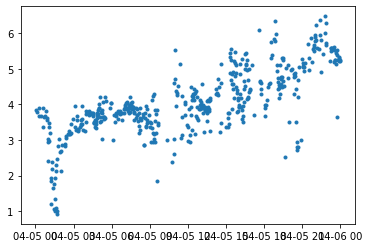

In [ ]:
##check the data
import matplotlib.pyplot as plt
#plt.plot(dscovr_cdf['Epoch1'][:],dscovr_cdf['B1F1'][:],'.',label='B1F1')
plt.plot(wind_cdf['Epoch'][:],wind_cdf['Proton_Np_nonlin'][:],'.')

**Step 4.** merge DSCOVR data based on WIND interval

**Step 4a.** 

Because each WIND data point is generated based on 92 sec MF data, and the interval of the data time in WIND data file is not even, we develop a method to merge DSCOVR data (one data point per second) based on WIND data's time and its interval. 

In [ ]:
#Read Epoch for DSCOVR and WIND
print(dscovr_cdf['Epoch1'])
print(wind_cdf['Epoch'])
WIND_array = wind_cdf['Epoch'][:]
DSCOVR_array = dscovr_cdf['Epoch1'][:]
len(WIND_array)
len(DSCOVR_array)
#for debug
#print(dscovr_cdf['Epoch1'][:])

In [ ]:
#Assign WIND time stamp index to DSCOVR data point
#The WIND Epoch of each data point is the beginning time of the specturm
#Each WIND time stampe correspond to 92 sec DSCOVR data point
WIND_index = 0
sec92 = 0
WIND_array = wind_cdf['Epoch'][:]
DSCOVR_array = dscovr_cdf['Epoch1'][:]
print(len(WIND_array))
print(WIND_array[len(WIND_array)-1:]) ##for debug - print the last item in the array to check the data
DSCOVR_time_range = [0]*86400
for i in range (0, len(DSCOVR_array)):
	if WIND_index <= len(WIND_array)-1:
		if (DSCOVR_array[i] > WIND_array[WIND_index]):  #find the start point in DSCOVR data that is in the interval of each WIND data point 
				if sec92 < 92: 
					DSCOVR_time_range[i]= WIND_index+1 #label 92 data point in DSCOVR for its correspond WIND data point 
					sec92 +=1
				else:
					sec92 = 0
					WIND_index += 1

In [ ]:
#for debug
#check the result
#np.savetxt("foo.csv", DSCOVR_time_range, delimiter=",")
print(DSCOVR_time_range[200])
print(DSCOVR_time_range[86398])

**Step 4b.**

Read MF data and write it in a array("DSCOVR_array"),
each row is one time point data (one second)
Include following data for training:
Epoch, B1F1, B1SDF1, B1GSE, B1SDGSE 

Read solar wind data, write it in array "WIND_array", 
use following data for training annotation
Epoch, Porton_V_nonlin, Proton_W_nonlin, Proton_Np_nonlin. 

For demo purpose, we creat the training data using Proton_Np_nonlin as label. 

The training data includes 8*92=736 MF features from DSCOVR.

***We just use the one day data to demostrate this pipeline. The trained neural network is for demo purpose only. One day's data  should be too less to train the neural network to get a good performance because of so many features.***

In [ ]:
##for debug
#check MF data in DSCOVR data and SWE data in WIND data
print(dscovr_cdf['B1GSE'][0,1])
print(wind_cdf['Proton_Np_nonlin'][1])
#print(len(DSCOVR_array))
#print(WIND_index+2)

In [ ]:
#define the size of the final training data
Training_array=np.zeros((len(WIND_array),737))
#Training_array=np.zeros((len(WIND_array),369))
#reset count
WIND_index = 0 # row
item736 = 0 #column
sec92 = 1
#entry the DSCOVR data and WIND data to the training array
for i in range (0, len(DSCOVR_array)-1):
  if DSCOVR_time_range[i] != 0:
    #if sec92 < 93:
    #  sec92 += 1
      if DSCOVR_time_range[i] == (WIND_index + 1):
        #print(DSCOVR_time_range[i],WIND_index)
        Training_array[WIND_index][item736]=dscovr_cdf['B1F1'][i]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1SDF1'][i]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1GSE'][i,0]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1GSE'][i,1]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1GSE'][i,2]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1SDGSE'][i,0]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1SDGSE'][i,1]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1SDGSE'][i,2]
        item736 +=1
        Training_array[WIND_index][736]=wind_cdf['Proton_Np_nonlin'][WIND_index]
      else:
        #print("WIND_index")
        WIND_index +=1
        item736 = 0
        Training_array[WIND_index][item736]=dscovr_cdf['B1F1'][i]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1SDF1'][i]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1GSE'][i,0]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1GSE'][i,1]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1GSE'][i,2]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1SDGSE'][i,0]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1SDGSE'][i,1]
        item736 +=1
        Training_array[WIND_index][item736]=dscovr_cdf['B1SDGSE'][i,2]
        item736 +=1

In [ ]:
#For debug
np.savetxt("foo_736.csv", Training_array, delimiter=",")

**Step 4c.**

Re-run step 1b, step3, step 4a to get another day's DSCOVR and WIND data for Validation 

In [ ]:
#define the size of the final Validation data
Validation_array=np.zeros((len(WIND_array),737))

#reset count
WIND_index = 0 # row
item736= 0 #column
sec92 = 1
#entry the DSCOVR data and WIND data to the training array
for i in range (0, len(DSCOVR_array)-1):
  if DSCOVR_time_range[i] != 0:
    #if sec92 < 93:
    #  sec92 += 1
      if DSCOVR_time_range[i] == (WIND_index + 1):
        #print(DSCOVR_time_range[i],WIND_index)
        Validation_array[WIND_index][item736]=dscovr_cdf['B1F1'][i]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1SDF1'][i]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1GSE'][i,0]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1GSE'][i,1]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1GSE'][i,2]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1SDGSE'][i,0]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1SDGSE'][i,1]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1SDGSE'][i,2]
        item736+=1
        Validation_array[WIND_index][736]=wind_cdf['Proton_Np_nonlin'][WIND_index]
      else:
        #print("WIND_index")
        WIND_index +=1
        item736= 0
        Validation_array[WIND_index][item736]=dscovr_cdf['B1F1'][i]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1SDF1'][i]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1GSE'][i,0]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1GSE'][i,1]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1GSE'][i,2]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1SDGSE'][i,0]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1SDGSE'][i,1]
        item736+=1
        Validation_array[WIND_index][item736]=dscovr_cdf['B1SDGSE'][i,2]
        item736+=1

In [ ]:
#for debug
print(Training_array.shape)
#print(Training_array[0][736])

In [ ]:
#for debug
print(Validation_array.shape)
print(Validation_array[0][736])

**Step 5.** Build the neural network

This is a regression question because this model will be used to predict the continue varable (solar wind speed, intensity, and temperature)

In [ ]:
## Dependencies
from sklearn.neural_network import MLPRegressor
import sklearn.metrics as metrics

Inital and configure the network (using default) https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html 
 and train the network using **fit()** method,  fit(training data array(DSCOVR), training data label array(WIND SWE))
 



Training the model using 2016/04/05 data

In [ ]:
#Establish the neural network with default seting with 100 hidden layers
neural_net = MLPRegressor(max_iter=200)

In [ ]:
#train the neural network using the 20160405 data
neural_net.fit(Training_array[:,:-1], Training_array[:,-1])

MLPRegressor(max_iter=2000)

Check some prediction using the trained neural network (**not for evaluation!!!**)

In [ ]:
res = neural_net.predict([[8.479391098022460938e+00,6.788202762603759766e+00,-5.061367034912109375e+00,4.343162775039672852e-01,8.537738800048828125e+00,6.686523914337158203e+00,-5.252315998077392578e+00,7.585624456405639648e-01,8.552853584289550781e+00,6.827000141143798828e+00,-5.085712432861328125e+00,8.107717633247375488e-01,8.533765792846679688e+00,6.740521430969238281e+00,-5.210933208465576172e+00,4.737089276313781738e-01,8.494697570800781250e+00,6.602684497833251953e+00,-5.283410549163818359e+00,7.890571355819702148e-01,8.506542205810546875e+00,6.844492912292480469e+00,-4.969867229461669922e+00,8.863670229911804199e-01,8.611404418945312500e+00,6.936623573303222656e+00,-5.070965290069580078e+00,5.443262457847595215e-01,8.568588256835937500e+00,6.691861152648925781e+00,-5.308078289031982422e+00,6.657086014747619629e-01,8.526492118835449219e+00,6.717085838317871094e+00,-5.171432495117187500e+00,9.087850451469421387e-01,8.622594833374023438e+00,6.929450988769531250e+00,-5.074331283569335938e+00,7.511968016624450684e-01,8.588807106018066406e+00,6.868764400482177734e+00,-5.132480621337890625e+00,4.783443510532379150e-01,8.496562004089355469e+00,6.640778064727783203e+00,-5.264559745788574219e+00,5.964617133140563965e-01,8.547043800354003906e+00,6.786623477935791016e+00,-5.121613979339599609e+00,8.631671071052551270e-01,8.600125312805175781e+00,6.830691337585449219e+00,-5.163957595825195312e+00,7.880998253822326660e-01,8.547677993774414062e+00,6.691432952880859375e+00,-5.200364589691162109e+00,1.099360942840576172e+00,8.564482688903808594e+00,6.978044033050537109e+00,-4.900247573852539062e+00,7.743327021598815918e-01,8.572033882141113281e+00,6.770965576171875000e+00,-5.228241920471191406e+00,4.950726330280303955e-01,8.527689933776855469e+00,6.611830234527587891e+00,-5.297547817230224609e+00,9.555909037590026855e-01,8.544025421142578125e+00,6.921423435211181641e+00,-4.934302806854248047e+00,8.464199304580688477e-01,8.536837577819824219e+00,6.838057994842529297e+00,-5.069562435150146484e+00,6.285523176193237305e-01,8.538093566894531250e+00,6.675505161285400391e+00,-5.238576889038085938e+00,9.415364265441894531e-01,8.526769638061523438e+00,6.739091396331787109e+00,-5.133854389190673828e+00,9.615808129310607910e-01,8.545684814453125000e+00,6.767519474029541016e+00,-5.158694267272949219e+00,7.832086086273193359e-01,8.537974357604980469e+00,6.793515205383300781e+00,-5.108167171478271484e+00,8.034738302230834961e-01,8.593746185302734375e+00,6.859821319580078125e+00,-5.111722469329833984e+00,8.105746507644653320e-01,8.543296813964843750e+00,6.664316177368164062e+00,-5.271723270416259766e+00,8.760383129119873047e-01,8.603070259094238281e+00,6.833710670471191406e+00,-5.106580734252929688e+00,1.102376341819763184e+00,8.580302238464355469e+00,6.968282699584960938e+00,-4.942415714263916016e+00,7.830706238746643066e-01,8.491393089294433594e+00,6.701793193817138672e+00,-5.175353050231933594e+00,6.220933198928833008e-01,8.539836883544921875e+00,6.640127658843994141e+00,-5.291853427886962891e+00,9.037007689476013184e-01,8.556987762451171875e+00,6.764155864715576172e+00,-5.135431766510009766e+00,1.042852759361267090e+00,8.613514900207519531e+00,6.899383068084716797e+00,-5.085163593292236328e+00,8.461558818817138672e-01,8.603702545166015625e+00,6.802426815032958984e+00,-5.213635444641113281e+00,7.485847473144531250e-01,8.547038078308105469e+00,6.745862483978271484e+00,-5.170329093933105469e+00,8.966653347015380859e-01,8.528645515441894531e+00,6.777293682098388672e+00,-5.110209941864013672e+00,8.279005289077758789e-01,8.564571380615234375e+00,6.756057739257812500e+00,-5.197690486907958984e+00,8.283686637878417969e-01,8.556885719299316406e+00,6.772399902343750000e+00,-5.171881198883056641e+00,7.725678682327270508e-01,8.585845947265625000e+00,6.721264839172363281e+00,-5.279564380645751953e+00,8.135893344879150391e-01,8.530828475952148438e+00,6.783108711242675781e+00,-5.092931270599365234e+00,9.054440259933471680e-01,8.497245788574218750e+00,6.773097038269042969e+00,-5.077906131744384766e+00,7.300109267234802246e-01,8.566027641296386719e+00,6.728798866271972656e+00,-5.260257720947265625e+00,6.516596078872680664e-01,8.566648483276367188e+00,6.734404087066650391e+00,-5.238700866699218750e+00,7.647168040275573730e-01,8.503086090087890625e+00,6.759490966796875000e+00,-5.104643821716308594e+00,7.400441765785217285e-01,8.476925849914550781e+00,6.701131343841552734e+00,-5.143421649932861328e+00,7.019891142845153809e-01,8.503718376159667969e+00,6.696470737457275391e+00,-5.180160999298095703e+00,7.935446500778198242e-01,8.511853218078613281e+00,6.753817558288574219e+00,-5.133961677551269531e+00,6.845210790634155273e-01,8.480693817138671875e+00,6.626547336578369141e+00,-5.266812801361083984e+00,5.111634135246276855e-01,8.451888084411621094e+00,6.499066352844238281e+00,-5.353253364562988281e+00,7.235034704208374023e-01,8.464600563049316406e+00,6.755808353424072266e+00,-5.019709110260009766e+00,8.807116746902465820e-01,8.495718002319335938e+00,6.840905666351318359e+00,-5.012835025787353516e+00,4.684378802776336670e-01,8.534031867980957031e+00,6.592102527618408203e+00,-5.368935108184814453e+00,7.010819911956787109e-01,8.482696533203125000e+00,6.722382545471191406e+00,-5.060002803802490234e+00,1.064053535461425781e+00,8.510353088378906250e+00,6.853988647460937500e+00,-4.997617721557617188e+00,6.661830544471740723e-01,8.472750663757324219e+00,6.616208553314208984e+00,-5.255696773529052734e+00,6.158894300460815430e-01,8.464020729064941406e+00,6.566996574401855469e+00,-5.271247386932373047e+00,8.469551205635070801e-01,8.546907424926757812e+00,6.748051166534423828e+00,-5.154897212982177734e+00,9.632404446601867676e-01,8.532818794250488281e+00,6.856452465057373047e+00,-5.025390625000000000e+00,7.264948487281799316e-01,8.480813026428222656e+00,6.668002605438232422e+00,-5.199572563171386719e+00,6.425420045852661133e-01,8.453410148620605469e+00,6.659270763397216797e+00,-5.151452064514160156e+00,7.531946301460266113e-01,8.476288795471191406e+00,6.682437896728515625e+00,-5.183309555053710938e+00,5.544379353523254395e-01,8.514239311218261719e+00,6.570741176605224609e+00,-5.325585365295410156e+00,9.506371617317199707e-01,8.501634597778320312e+00,6.851589679718017578e+00,-4.945520401000976562e+00,9.046584367752075195e-01,8.484717369079589844e+00,6.708552837371826172e+00,-5.178314208984375000e+00,3.733414113521575928e-01,8.492430686950683594e+00,6.556511878967285156e+00,-5.349487781524658203e+00,7.025121450424194336e-01,8.546821594238281250e+00,6.765610694885253906e+00,-5.163388252258300781e+00,7.756365537643432617e-01,8.571989059448242188e+00,6.812230587005615234e+00,-5.176058769226074219e+00,5.185044407844543457e-01,8.506564140319824219e+00,6.697799682617187500e+00,-5.216026782989501953e+00,5.358542203903198242e-01,8.437226295471191406e+00,6.702230453491210938e+00,-5.082157611846923828e+00,6.581974625587463379e-01,8.461677551269531250e+00,6.706222534179687500e+00,-5.127966403961181641e+00,5.699824690818786621e-01,8.514238357543945312e+00,6.660793304443359375e+00,-5.261642456054687500e+00,6.578014492988586426e-01,8.505857467651367188e+00,6.714835643768310547e+00,-5.168665885925292969e+00,7.340929508209228516e-01,8.513648986816406250e+00,6.746226310729980469e+00,-5.156211853027343750e+00,6.160008311271667480e-01,8.551645278930664062e+00,6.757643222808837891e+00,-5.194439411163330078e+00,6.915026307106018066e-01,8.497414588928222656e+00,6.701752662658691406e+00,-5.175602436065673828e+00,7.071328163146972656e-01,8.508762359619140625e+00,6.698392868041992188e+00,-5.179896831512451172e+00,8.334000706672668457e-01,8.520072937011718750e+00,6.786688804626464844e+00,-5.083863735198974609e+00,8.247018456459045410e-01,8.479574203491210938e+00,6.741956710815429688e+00,-5.099581718444824219e+00,6.607608199119567871e-01,8.526163101196289062e+00,6.668148994445800781e+00,-5.253095149993896484e+00,7.897459864616394043e-01,8.521157264709472656e+00,6.743859291076660156e+00,-5.123786449432373047e+00,9.289472699165344238e-01,8.526417732238769531e+00,6.872489452362060547e+00,-4.982157230377197266e+00,7.992566823959350586e-01,8.549106597900390625e+00,6.824576377868652344e+00,-5.110542297363281250e+00,6.214225292205810547e-01,8.543501853942871094e+00,6.728340148925781250e+00,-5.221822738647460938e+00,6.682874560356140137e-01,8.534698486328125000e+00,6.710703849792480469e+00,-5.211764812469482422e+00,7.991744279861450195e-01,8.563000679016113281e+00,6.810116767883300781e+00,-5.122507572174072266e+00,8.367620110511779785e-01,8.572348594665527344e+00,6.850231647491455078e+00,-5.108425140380859375e+00,6.773514151573181152e-01,8.548279762268066406e+00,6.844474792480468750e+00,-5.062957763671875000e+00,7.669659256935119629e-01,8.516163825988769531e+00,6.824757575988769531e+00,-5.052468299865722656e+00,6.405616402626037598e-01,8.547143936157226562e+00,6.758704185485839844e+00,-5.191376209259033203e+00,6.405613422393798828e-01,8.524496078491210938e+00,6.752161979675292969e+00,-5.128668308258056641e+00,8.732297420501708984e-01,8.527452468872070312e+00,6.857575893402099609e+00,-5.004310131072998047e+00,8.013752102851867676e-01,8.573149681091308594e+00,6.893260002136230469e+00,-5.040480136871337891e+00,7.550625801086425781e-01,8.578152656555175781e+00,6.883796215057373047e+00,-5.080734252929687500e+00,6.138940453529357910e-01]])

In [ ]:
#Ground Truth: 3.83
print(res)


[3.195324]


Step 6. Evaluate the performance of the trained neural network

***Due to limit size of the demo training data (only one day) and large features we included in this model, the evaluation of the performance may not be accurate.*** We will use more data to train this neural network. 

For demo purpose, you can just use one feature per second (such as B1F1 only) by modify the step 4b and 4c.


In [ ]:
#Y_test = Validation_array[:,-1]
Y_test = Training_array[:,-1]


In [ ]:
print(Training_array[1][736])

In [ ]:
#print(Y_test)
np.savetxt("Y_test.csv", Y_test, delimiter=",")

In [ ]:
#Y_pre = neural_net.predict(Validation_array[:,:-1])
Y_pre = neural_net.predict(Training_array[:,:-1])
#np.set_printoptions(formatter={'float_kind':'{:f}'.format})
#print(Y_pre)

In [ ]:
#print(Y_pre)
np.savetxt("Y_pre.csv", Y_pre, delimiter=",")

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(Y_test, Y_pre)
plt.show()

In [ ]:
from sklearn.metrics import r2_score
print('Training R^2     : %.3f'%r2_score(Y_test, Y_pre))

Next step: Study **Time-related feature engineering**
https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py 